# Курсовая работа

Подключим неоходимое для работы:

In [240]:
%matplotlib notebook

import math
from math import *
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy
import filterpy
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_continuous_white_noise
from filterpy.common import Q_discrete_white_noise
#import code.book_plots as bp
from scipy import stats
from filterpy.common import van_loan_discretization
from scipy.linalg import expm

Выберем необходимые геодезические константы:

In [65]:
R_earth = 6371000
a = 6378137.0
b = 6356752.0
e2 = 6.6943799901413 * (10 ** -3)
delta_t = 0.005
phi_0 = 31.2        #initial latitude
lambda_0 = 121.3    #initial longitude
h_0 = 4             #initial altitude
u = 2 * pi / 86164.090530833

Переведём данные в удобный для работы формат и далее сохраним их в пикл (чтобы можно было быстро работать с этой структурой данных):

In [15]:
def CNFparser(filename):
    '''
    Тут мы расписываем парсер
    CNFnav - кусок для работы в режиме навигации
    CNFalign - кусок для выставки (причём секунд 10-20 из него для алгебраической, остальное на кинематику)
    '''
    CNFnames = ['Time','AccX','AccY','AccZ','OmX','OmY','OmZ']
    CNF = pd.read_table(filename, sep = '\s+' ,header = None, names = CNFnames)
    #CNFalign = CNF[CNF.FlagAlignment == 1]
    #CNFalign = CNFalign.loc[:,['Time','OmX','OmY','OmZ','AccX','AccY','AccZ']]
    #CNFnav = CNF[CNF.FlagAlignment == 0]
    #CNFnav = CNFnav.loc[:,['Time','OmX','OmY','OmZ','AccX','AccY','AccZ']]
    #CNF = []
    CNF['Invariant'] = CNF.AccX*CNF.OmX +  CNF.AccY*CNF.OmY +  CNF.AccZ*CNF.OmZ
    CNF['g\''] = (CNF.AccX**2 + CNF.AccY**2 + CNF.AccZ**2)**(0.5)
    CNF['W_Std500'] = (CNF.Invariant.rolling(window = 500, center = False).std()).dropna()
    return CNF

Считаем данные:

In [16]:
CNF = CNFparser('IMU_coursework.txt')

In [30]:
CNF.to_pickle('IMU_df.pkl')

In [2]:
CNF = pd.read_pickle('IMU_df.pkl')

Исследуем данные:

<IPython.core.display.Javascript object>


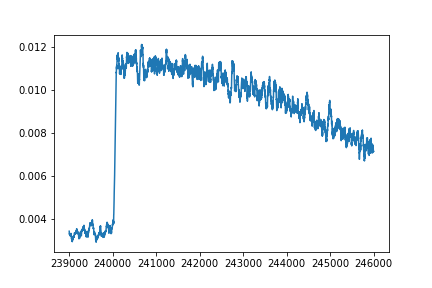

In [241]:
plt.plot(CNF.AccY.rolling(window = 100, center = False).std()[239000:])

Видно какой-то удар: СКО резко увеличивается. Видимо, это начало движения

<IPython.core.display.Javascript object>


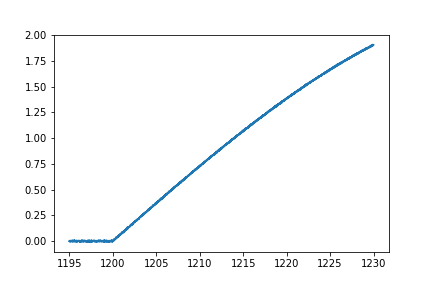

In [244]:
plt.plot(CNF.Time[239000:],CNF.AccY[239000:])

<IPython.core.display.Javascript object>


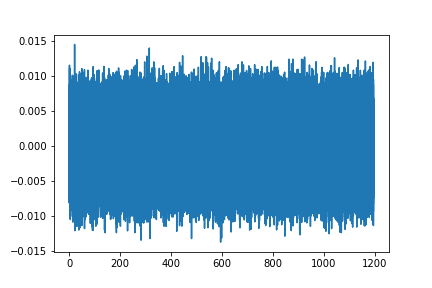

In [243]:
plt.plot(CNF.Time[:239000],CNF.AccY[:239000])

Реализуем формулу Гельмерта:

In [230]:
def g_phi(phi, h, a, e2):
    #g1 = 9.78030 * (1 - 2 * h / a + 3 * e2 * sin(phi) ** 2 / 4)
    g = 9.78030*(1+0.005302*sin(phi)*sin(phi)-0.000007*sin(2*phi)*sin(2*phi))
    return g

In [229]:
g_phi(phi_0, h_0, a, e2)

-0.00012652682219460587

Выделим часть данных для начальной выставки:

In [231]:
CNFinit = CNF.loc[:240000,['Time','AccX','AccY','AccZ','OmX','OmY','OmZ']].values

Реализуем функцию начальной алгебраической выставки для получения матрицы ориентации L:

In [233]:
def initial_calibration(A, phi, h, a, e2, u):
    L = np.zeros((3, 3))
    means = np.mean(A[:, 1:], axis = 0).reshape(6,1)
    L[:, 2:3] = means[0:3] / g_phi(phi, h, a, e2)
    L[:, 1:2] = (means[3:6] - (L[:, 2:3] * u * sin(phi))) / (u * cos(phi))
    L[:, 0:1] = np.cross(L[:, 1:2].T, L[:, 2:3].T).T
    L[:, 2:3] /= np.linalg.norm(L[:, 2:3], 2)
    L[:, 1:2] /= np.linalg.norm(L[:, 1:2], 2)
    L[:, 0:1] /= np.linalg.norm(L[:, 0:1], 2)
    return L

In [234]:
L_0  = initial_calibration(CNFinit, phi_0, h_0, a, e2, u)
print L_0, np.linalg.det(L_0)

[[  9.91163697e-01  -1.01030173e-01   1.46150649e-06]
 [  1.32644361e-01   7.54938419e-01  -6.29075429e-07]
 [ -1.36514887e-06   6.47966733e-01   1.00000000e+00]] 0.761669166455


Выполним руками:

In [163]:
CNF.OmY.loc[:240000].mean()

Time         600.000000
AccX           0.000014
AccY          -0.000006
AccZ           9.794006
OmX           -0.000008
OmY            0.000062
OmZ            0.000037
Invariant      0.000365
g'             9.794007
W_Std500       0.000067
dtype: float64

In [ ]:
om_y = CNFnav['OmY'][DELIMITER0:DELIMITER].mean()  
om_z = CNFnav['OmZ'][DELIMITER0:DELIMITER].mean()
f_x = CNFnav['AccX'][DELIMITER0:DELIMITER].mean()
f_y = CNFnav['AccY'][DELIMITER0:DELIMITER].mean()
f_z = CNFnav['AccZ'][DELIMITER0:DELIMITER].mean()

In [175]:
    om_x = CNF.OmX.loc[:240000].mean()
    om_y = CNF.OmY.loc[:240000].mean()  
    om_z = CNF.OmZ.loc[:240000].mean()
    f_x = CNF.AccX.loc[:240000].mean()
    f_y = CNF.AccY.loc[:240000].mean()
    f_z = CNF.AccZ.loc[:240000].mean()

In [188]:
print (om_x**2 + om_y**2 + om_z**2)**(0.5) - 0.000072921158553
print (f_x**2 + f_y**2 + f_z**2)**(0.5) - g_phi(phi_0, h_0, a, e2)

-3.5589482315e-07
0.0114638210749


In [173]:
def InitialAlgebraicAlignment():
    global g
    global L
    global theta, gamma, phi, psi, psi_al, theta_al, gamma_al, L_al
    DELIMITER0 = 29986  #начало интервала наименьшего вибрационного воздействия
    DELIMITER = 50004   #конец периода наименьшего вибрационного воздействия (получены на первой курсовой)
    u = 0.000072921158553
    Pi = 3.14159265358979323846
    om_x = CNF.OmX.loc[:240000].mean()
    om_y = CNF.OmY.loc[:240000].mean()  
    om_z = CNF.OmZ.loc[:240000].mean()
    f_x = CNF.AccX.loc[:240000].mean()
    f_y = CNF.AccY.loc[:240000].mean()
    f_z = CNF.AccZ.loc[:240000].mean()
    theta = math.atan2(f_x, math.sqrt(f_y*f_y+f_z*f_z))
    gamma = -math.atan2(f_z, f_y)
    phi = 31.2
    g = 9.78030*(1+0.005302*sin(phi)*sin(phi)-0.000007*sin(2*phi)*sin(2*phi))
    om = math.sqrt(om_x*om_x+om_y*om_y+om_z*om_z)
    l13 = sin(theta)
    l23 = cos(theta)*cos(gamma)
    l33 = -cos(theta)*sin(gamma)
    l12 = (om_x - u*l13*sin(phi))/(u*cos(phi))
    l22 = (om_y - u*l23*sin(phi))/(u*cos(phi))
    l32 = (om_z - u*l33*sin(phi))/(u*cos(phi))
    l12 = l12/(sqrt(l12*l12+l22*l22+l32*l32)) #нормировка
    l22 = l22/(sqrt(l12*l12+l22*l22+l32*l32))
    l32 = l32/(sqrt(l12*l12+l22*l22+l32*l32))
    #теперь нужно векторно умножить второй на третий
    l11 = l22*l33 - l32*l23
    l21 =-l12*l33 + l13*l32
    l31 = l12*l23 - l22*l13
    L = np.matrix([[l11, l12, l13], [l21, l22, l23], [l31, l32, l33]])   #записали в матрицу
    psi = math.atan2(L.item(0,0),L.item(0,1))
    theta = math.asin(L.item(0,2))
    gamma = -math.atan2(L.item(2,2),L.item(1,2))
    psi_al = psi                                      
    theta_al = theta
    gamma_al = gamma
    L_al = L
    return L_al

In [207]:
L_1 = InitialAlgebraicAlignment()
print L_1, np.linalg.det(L_1)
print L_0, np.linalg.det(L_0)

[[  7.55935391e-01  -1.00952025e-01   1.32002953e-06]
 [  1.00952946e-01   7.55934697e-01  -9.94612397e-07]
 [ -8.97447985e-07   6.97921927e-01   1.00000000e+00]] 0.581629812858
[[  9.91163697e-01  -1.01030011e-01   1.46150649e-06]
 [  1.32644361e-01   7.54937208e-01  -6.29075429e-07]
 [ -1.36514887e-06   6.47968170e-01   1.00000000e+00]] 0.761667944584


In [168]:
print np.linalg.det(L)

0.581707009351


In [147]:
print L_0

[[ -9.91163697e-01   1.46150514e-06  -1.13770529e-01]
 [ -1.32644361e-01  -6.29065369e-07   8.50137307e-01]
 [  1.36514887e-06   1.00000000e+00   5.14123356e-01]]


In [148]:
print np.linalg.det(L_0)

0.857716675435


In [68]:
L = np.zeros((3, 3))

In [134]:
A = CNF.loc[:240000,['Time','AccX','AccY','AccZ','OmX','OmY','OmZ']].values

In [142]:
means = np.mean(A[:, 1:], axis = 0)

In [143]:
print means

[  1.43140028e-05  -6.16116832e-06   9.79400567e+00  -8.25578845e-06
   6.16904379e-05   3.73074969e-05]


In [98]:
L[:,2:3] = means[3:] / g_phi(phi_0, h_0, a, e2)

In [89]:
L = np.linspace(1, 9, num = 9).reshape(3,3)
L

array([[ 1.,  2.,  3.],
       [ 4.,  5.,  6.],
       [ 7.,  8.,  9.]])

In [87]:
L[:,2:3]

array([[ 3.],
       [ 6.],
       [ 9.]])

In [101]:
L[:, 1:2]

array([[ 2.],
       [ 5.],
       [ 8.]])

In [104]:
L[:, 1:2] = (means[0:3] - (L[:, 2:3] * u * sin(phi_0))) / (u * cos(phi_0))

In [120]:
L

array([[ -8.67116173e-01,   2.00974562e-01,  -8.43930929e-07],
       [ -1.16043431e-01,  -8.62621403e-02,   6.30617959e-06],
       [  1.19458240e-06,   1.37502561e+05,   3.81368658e-06]])

In [119]:
L[:, 0:1] = np.cross(L[:, 1:2].T, L[:, 2:3].T).T

In [122]:
L[:, 2:3] /= np.linalg.norm(L[:, 2:3], 2)